In [ ]:
import tensorflow as tf
import numpy as np

## Implementing RNNs from Scratch

In [ ]:
class MyRNNCell(tf.keras.layers.Layer):
    def __init__(self, rnn_units, input_dims, output_dims):
        super(MyRNNCell, self).__init__()
        
#       Initialize weight matrices
        self.W_xh = self.add_weight([rnn_units, input_dims])
        self.W_hh = self.add_weight([rnn_units, rnn_units])
        self.W_hy = self.add_weight([output_dims, rnn_units])
        
#         Initialize hidden state to 0
        self.h = tf.zeros([rnn_units, 1])
    
    def call(self, x):
        self.h = tf.math.tanh(self.W_hh * self.h + self.W_xh * self.x )
        
#         Computing the output
        output = self.W_hy * self.h
        
#         return current output and hidden state
        return output, self.h

In [ ]:
# tensorflow abstraction for RNNs: 
from tensorflow.keras.layers import SimpleRNN

rnn_units = 5
tfRnn = SimpleRNN(rnn_units)

## Predicting Stock Prices using RNN

[*********************100%%**********************]  1 of 1 completed


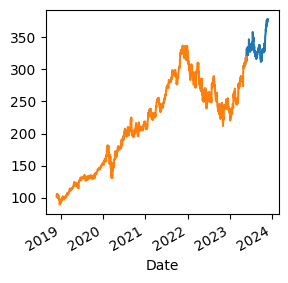

In [109]:
import yfinance as yf
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

data = yf.download('MSFT', period='5y', interval='1d')
data_target = data.iloc[:1130, 4]
data_test = data.iloc[1110:, 4]
steps = 7 # 7 day patterns and price would be recorded as independant
# Return numpy representation of the data
data = data.loc[:, ['Adj Close']].values
test = data[len(data) - len(data_test) - steps:]
plt.figure(figsize=(3,3))
plot = data_test.plot()
plot2 = data_target.plot()

(1130,)
(1130,)


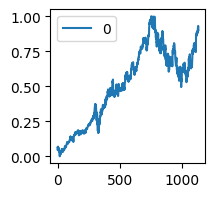

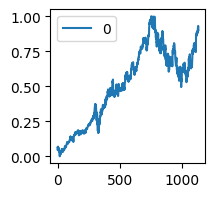

In [112]:
# Scaling dataset
def scaledata(data_target):
#     import scalar and initialize
    scaler = MinMaxScaler(feature_range=(0,1))
    # Converting to array if shape (-1, 1)
    data_target_scaled = scaler.fit_transform(np.array(data_target).
                                              reshape(-1,1)
                                             )
#     Plot the scaled version of the data
    plot_scaled = pd.DataFrame(data_target_scaled).plot(figsize=(2,2))
    print(data_target.shape)
    
    return data_target_scaled, scaler
# Create pattern and end price set
def createPatternSet(data_target_scaled, steps=7):
    x_pattern = [] # independant variable
    y_price = [] # Dependant variable
    
    for day in range(steps, data_target_scaled.shape[0]):
        row = data_target_scaled[day-steps:day, 0]
        x_pattern.append(row)
        y = data_target_scaled[day, 0]
        y_price.append(y)
    x_pattern, y_price = np.array(x_pattern),np.array(y_price)
#     LSTM and RNN take 3D inputs, reshaping the array into 3D
    x_pattern = x_pattern.reshape(x_pattern.shape[0], 
                                  x_pattern.shape[1], 1)
    
    return x_pattern, y_price

# Scale down target
data_target_scaled = scaledata(data_target)[0]
scalar = scaledata(data_target)[1]

# Prepare test data
test = data[len(data)-len(data_test)-steps : ]
test = scalar.transform(test)

In [7]:
# building x_train and y_train
train_pattern = createPatternSet(data_target_scaled, steps = 50)
x_train = train_pattern[0]
y_train = train_pattern[1]
print(x_train.shape)

# Creating testing set
test_pattern = createPatternSet(test, steps = 50)
x_test = test_pattern[0]
y_test = test_pattern[1]
print(x_test.shape)

(1080, 50, 1)
(105, 50, 1)


In [107]:
class StocksRNN():
    loss = 'mean_squared_error'
    batch_size=32
    neurons=50
    model = tf.keras.Sequential()
    
    def __init__(self, x_train, y_train, epochs, loss='mean_squared_error', neurons=50, batch_size=32):
        self.x_train = x_train
        self.y_train = y_train
        self.epoch = epochs
        self.loss=loss
        self.neurons = neurons
        self.batch_size=batch_size
        
    def RNNArchitecture(self, rnn=2, dense=1):
        StocksRNN.model.add(tf.keras.layers.SimpleRNN(self.neurons,
                                      activation='tanh',
                                      return_sequences=True,
                                      input_shape=(self.x_train.shape[1],1)
                                     ))
        StocksRNN.model.add(tf.keras.layers.Dropout(0.2))
        
        for i in range(rnn):
            StocksRNN.model.add(tf.keras.layers.SimpleRNN(self.neurons,
                                                         activation='tanh',
                                                         return_sequences=True))
            StocksRNN.model.add(tf.keras.layers.Dropout(0.2))
            
#         Return with return_sequences=False
        StocksRNN.model.add(tf.keras.layers.SimpleRNN(self.neurons,
                                                     activation='tanh',
                                                     return_sequences=False
                                                     ))
        StocksRNN.model.add(tf.keras.layers.Dropout(0.2))
        
#         Adding Dense layers for output
        for i in range(dense):
            StocksRNN.model.add(tf.keras.layers.Dense(self.neurons,
                                                     activation='tanh'))
#         Output
        StocksRNN.model.add(tf.keras.layers.Dense(units = 1))
        return StocksRNN.model.summary()        
    
    def compiler(self):
        opt = tf.keras.optimizers.Adam()
        StocksRNN.model.compile(optimizer=opt,
                               loss = StocksRNN.loss)
        return StocksRNN.model.summary()
    
    def modelfit(self):
        history = StocksRNN.model.fit(self.x_train, self.y_train,
                                     epochs=self.epoch,
                                     batch_size=self.batch_size, 
                                     validation_split=0.2)
        return history
    @staticmethod
    def plotting(org_vals,output):
        plt.figure(figsize=(5,3), dpi=80, facecolor='w', edgecolor='k')
        plt.plot(org_vals,label="Org value")
        plt.plot(output,label="Predicted")
        plt.legend()
        plt.xlabel("Days")
        plt.ylabel("Price")
        plt.grid(True)
        plt.show()

In [87]:
RNN1 = StocksRNN(x_train, y_train, 50, neurons=65)

In [88]:
RNN1.RNNArchitecture()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_53 (SimpleRNN)   (None, 50, 65)            4355      
                                                                 
 dropout_33 (Dropout)        (None, 50, 65)            0         
                                                                 
 simple_rnn_54 (SimpleRNN)   (None, 50, 65)            8515      
                                                                 
 dropout_34 (Dropout)        (None, 50, 65)            0         
                                                                 
 simple_rnn_55 (SimpleRNN)   (None, 50, 65)            8515      
                                                                 
 dropout_35 (Dropout)        (None, 50, 65)            0         
                                                                 
 simple_rnn_56 (SimpleRNN)   (None, 65)               

In [89]:
RNN1.compiler()
history = RNN1.modelfit()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_53 (SimpleRNN)   (None, 50, 65)            4355      
                                                                 
 dropout_33 (Dropout)        (None, 50, 65)            0         
                                                                 
 simple_rnn_54 (SimpleRNN)   (None, 50, 65)            8515      
                                                                 
 dropout_34 (Dropout)        (None, 50, 65)            0         
                                                                 
 simple_rnn_55 (SimpleRNN)   (None, 50, 65)            8515      
                                                                 
 dropout_35 (Dropout)        (None, 50, 65)            0         
                                                                 
 simple_rnn_56 (SimpleRNN)   (None, 65)               

In [91]:
pred = RNN1.model.predict(x=x_test)
pred.shape

4/4 [==============================] - 3s 38ms/step


(105, 1)

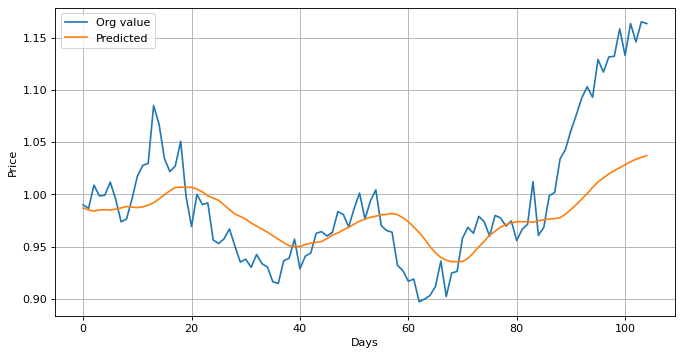

In [108]:
# plt.figure(figsize=(2,2))
plotting(y_test, pred)

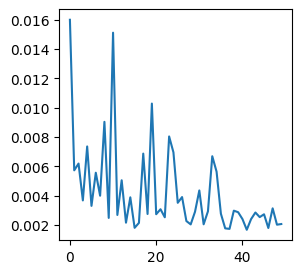

In [103]:
plt.figure(figsize=(3,3))
plt.plot(history.history['val_loss'])

In [71]:
RNN3 = StocksRNN(x_train, y_train, 25)

In [72]:
RNN3.RNNArchitecture(2, 0)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_43 (SimpleRNN)   (None, 50, 50)            2600      
                                                                 
 dropout_25 (Dropout)        (None, 50, 50)            0         
                                                                 
 simple_rnn_44 (SimpleRNN)   (None, 50, 50)            5050      
                                                                 
 dropout_26 (Dropout)        (None, 50, 50)            0         
                                                                 
 simple_rnn_45 (SimpleRNN)   (None, 50, 50)            5050      
                                                                 
 dropout_27 (Dropout)        (None, 50, 50)            0         
                                                                 
 simple_rnn_46 (SimpleRNN)   (None, 50)               

In [73]:
RNN2.compiler()
history2 = RNN2.modelfit()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_43 (SimpleRNN)   (None, 50, 50)            2600      
                                                                 
 dropout_25 (Dropout)        (None, 50, 50)            0         
                                                                 
 simple_rnn_44 (SimpleRNN)   (None, 50, 50)            5050      
                                                                 
 dropout_26 (Dropout)        (None, 50, 50)            0         
                                                                 
 simple_rnn_45 (SimpleRNN)   (None, 50, 50)            5050      
                                                                 
 dropout_27 (Dropout)        (None, 50, 50)            0         
                                                                 
 simple_rnn_46 (SimpleRNN)   (None, 50)               

4/4 [==============================] - 1s 56ms/step


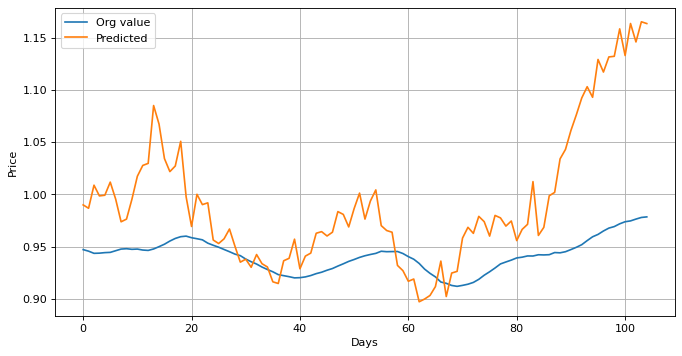

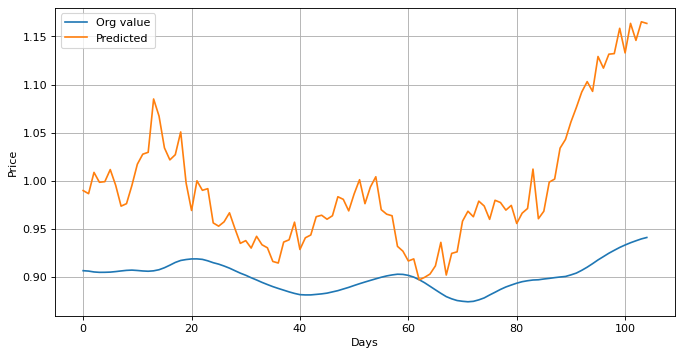

In [74]:
pred2=RNN2.model.predict(x_test)
plotting(pred, y_test)
plotting(pred2, y_test)

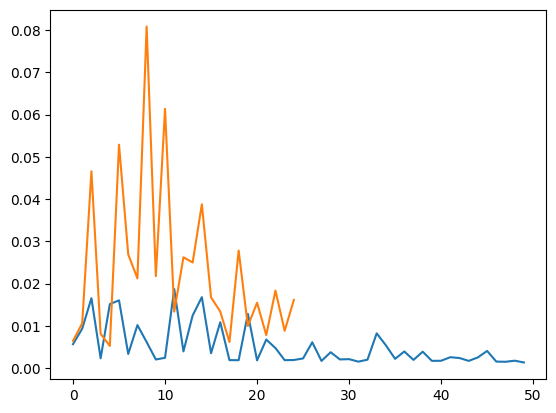

In [75]:
plt.plot(history.history['val_loss'])
plt.plot(history2.history['val_loss'])
plt.show()

In [77]:
history.history['val_loss'][-1]

0.0013563208049163222

In [78]:
history2.history['val_loss'][-1]

0.016149766743183136